# This note book compare the compressed snapshot with original snapshot

In [1]:
import numpy as np
from readers import HaloReader,SnapshotReader
from correlations import PowerSpectrum
from time import time
import gc

import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import pylab as pl

import h5py

import socket
print(socket.gethostname())



pawna


# Setup the simulation paths

In [2]:
#sim_stem = 'sinhagad/default256'
#on pawna
sim_stem='sinhagad/default128'
snap = 200
real = 1
grid = 128
downsample=0
Npmin = 30

Seed = 42


# setup the snapshot object

In [3]:
sr = SnapshotReader(sim_stem=sim_stem,real=real,snap=snap,read_header=False)

Snapshot Reader:
... preparing to read file: sinhagad/default128/r1/snapshot_200.hdf5


# Now make the choies of compression

In [4]:
# The compressed file will be split in several percentage subsample
# One if free to choose this setting with following requirement
# a) The sum of the subsamples must add to 100
# b) The elements must be unique that is same subsample cannot be created twice because the file neme convention

subsamples=[1,3,6,10,30,50]

# read the header
sr.read_snapshot_header()

# The directory in the output directory to store compressed output
compressed_fileroot='compressed'

# This call reads the original snapshot and write the compressed file
sr.compress_snapshot( subsamples)


... loaded header and parameters
Compressing snapshot data and saving header...
Reading HDF5 groups and writing to JSON: /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_info.json
JSON file created: /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_info.json
Snapshot information saved to: /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_info.json
... reading Coordinates
0 Compression complete /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample1_positions.h5
1 Compression complete /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample3_positions.h5
2 Compression complete /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample6_positions.h5
3 Compression complete /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample10_positions.h5
4 Compression complete /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample30_positio

In [5]:
# look at the size of directory for the compressed snapshot
!du -sh /storage/shadab/sims/sinhagad/default128/r1/compressed/
!du -sh /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample*_ids.h5

23M	/storage/shadab/sims/sinhagad/default128/r1/compressed/
600K	/storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample10_ids.h5
72K	/storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample1_ids.h5
1.7M	/storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample30_ids.h5
192K	/storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample3_ids.h5
2.6M	/storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample50_ids.h5
368K	/storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_subsample6_ids.h5


In [6]:
# look at the size of original snapshot file
!ls -ltrh /storage/shadab/sims/sinhagad/default128/r1/snapshot_200.hdf5

-rw------- 1 shadab users 65M Sep 18 15:03 /storage/shadab/sims/sinhagad/default128/r1/snapshot_200.hdf5


# The size comprasion
In this case the original file had 65 MB the compressed directory has 23 MB out of which 5 MB is just for id which we should be able to improve. Currently this gives about factor of 3 lower storage.

Note the this can be higher for higher resolution run. Currently a Ngrid=Lbox is used to store grid information which is more than number of particels and give approx 2kpc/h maximum error. For a higher resolution run this kind of storage will become negligible and give us better compression factor than the current scenario.


# Let us now use the same function to read original files and load the information in a dictionary

In [7]:
# By setting use_compress=False we are asking to read from original file for snapshot
sr_o = SnapshotReader(sim_stem=sim_stem,real=real,snap=snap,read_header=True,use_compressed=False)
# By setting use_compress=True we are asking to read from compressed file
sr_comp = SnapshotReader(sim_stem=sim_stem,real=real,snap=snap,read_header=True,use_compressed=True)

Snapshot Reader:
... preparing to read file: sinhagad/default128/r1/snapshot_200.hdf5
... loaded header and parameters
Snapshot Reader:
... preparing to read file: sinhagad/default128/r1/snapshot_200.hdf5
Header information loaded from: /storage/shadab/sims/sinhagad/default128/r1/compressed/snapshot_200_info.json
... loaded header and parameters


# Load both the quantities from the compressed and original files

In [8]:
res_dic={'original':{},'compressed':{}}
for tt,tkey in enumerate(['ids','pos','vel','potential']):
    res_dic['original'][tkey] = sr_o.read_block(tkey).T
    res_dic['compressed'][tkey] = sr_comp.read_block(tkey)
    print(tt,tkey,res_dic['original'][tkey].shape, res_dic['compressed'][tkey].shape)

# This is need to make sure the coordinate exactly equl to Lbox is set to zero
for ii in range(0,3):
    res_dic['original']['pos'][:,ii]=res_dic['original']['pos'][:,ii]%sr_comp.Lbox

... reading ParticleIDs
Loading compressed data for subsamples [1, 3, 6, 10, 30, 50]...
Decompression complete.
0 ids (2097152,) (2097152,)
... reading Coordinates
Loading compressed data for subsamples [1, 3, 6, 10, 30, 50]...
Decompression complete.
1 pos (2097152, 3) (2097152, 3)
... reading Velocities
Loading compressed data for subsamples [1, 3, 6, 10, 30, 50]...
Decompression complete.
2 vel (2097152, 3) (2097152, 3)
... reading Potential
Loading compressed data for subsamples [1, 3, 6, 10, 30, 50]...
Decompression complete.
3 potential (2097152,) (2097152,)


In [10]:
# We would like to sort the quantities by ids because the orders are different in compressed file
sort_ind={'original':np.argsort(res_dic['original']['ids']),
          'compressed':np.argsort(res_dic['compressed']['ids'])
         }

# Now compare the quantities to look at the differences

0 ids mean: 0.0 std: 0.0 min: 0 max: 0
1 pos mean: -6.097382695408512e-08 std: 0.001132220444917334 min: -0.001960784313723707 max: 0.001960777768901689
2 vel mean: 7.66715753788813e-05 std: 0.8458955194691418 min: -1.465657552082689 max: 1.4655297806842498
3 potential mean: -24.420024420024397 std: 6.394884621840902e-14 min: -24.420024420024333 max: -24.420024420024333


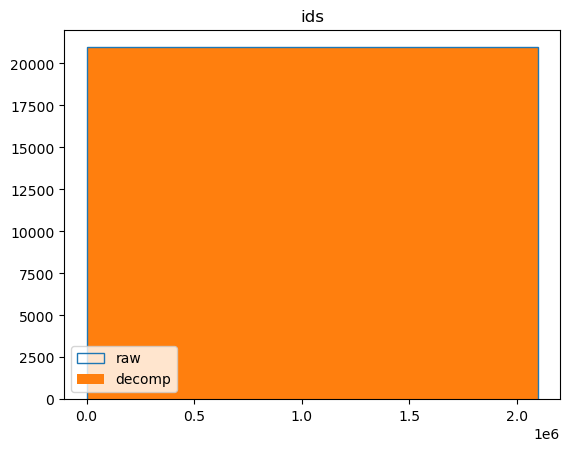

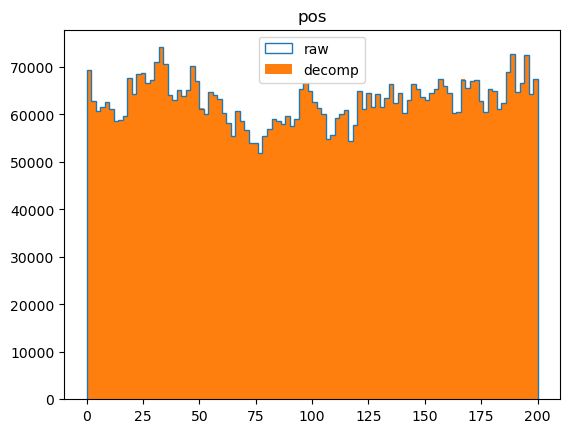

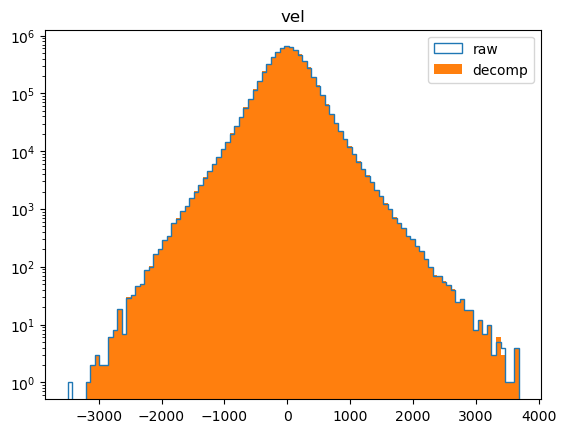

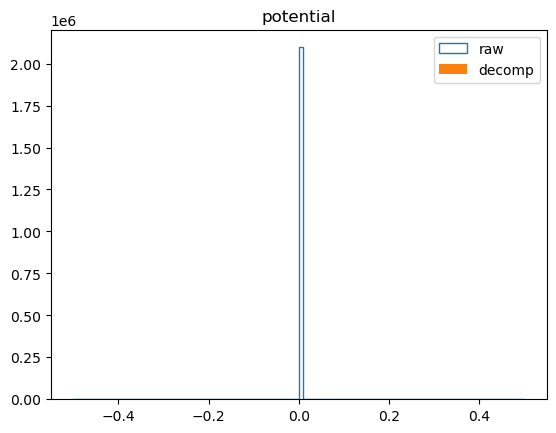

In [11]:

for tt,tkey in enumerate(res_dic['original'].keys()):   
    diff=res_dic['original'][tkey][sort_ind['original']]-res_dic['compressed'][tkey][sort_ind['compressed']]
    print(tt,tkey, 'mean:',diff.mean(),'std:',diff.std(),'min:',diff.min(),'max:',diff.max())
    pl.figure();pl.title(tkey)
    hh=pl.hist(res_dic['original'][tkey].flatten(),bins=100,histtype='step',label='raw')
    hh=pl.hist(res_dic['compressed'][tkey].flatten(),bins=hh[1],label='decomp')
    if(tkey=='vel'):
        pl.yscale('log')
    pl.legend()

# Compare the power spectrum

In [14]:
pk_dic={'raw':{},'comp':{}}

ps = PowerSpectrum(grid=512,Lbox=sr.Lbox)
delta_dm = ps.density_field(res_dic['original']['pos'].T)
FT_delta_dm = ps.fourier_transform_density(delta_dm)
pk_dic['raw']['mm'] = ps.Pk_grid(FT_delta_dm,input_is_FTdensity=True)
if downsample > 0:
    pk_dic['raw']['mm'] -= ps.Lbox**3/(downsample**3)
else:
    pk_dic['raw']['mm'] -= ps.Lbox**3/(sr.npart)


ps = PowerSpectrum(grid=512,Lbox=sr.Lbox)
delta_dm = ps.density_field(res_dic['compressed']['pos'].T)
FT_delta_dm = ps.fourier_transform_density(delta_dm)
pk_dic['comp']['mm'] = ps.Pk_grid(FT_delta_dm,input_is_FTdensity=True)
if downsample > 0:
    pk_dic['comp']['mm'] -= ps.Lbox**3/(downsample**3)
else:
    pk_dic['comp']['mm'] -= ps.Lbox**3/(sr.npart)

Setting up k-space...
... using log binning
... creating mesh
... setting up index arrays
... done with setup
Computing density field...
... updating density
... deconvolving CIC filter
... calculating P(k)
Setting up k-space...
... using log binning
... creating mesh
... setting up index arrays
... done with setup
Computing density field...
... updating density
... deconvolving CIC filter
... calculating P(k)


Text(0, 0.5, 'Pk')

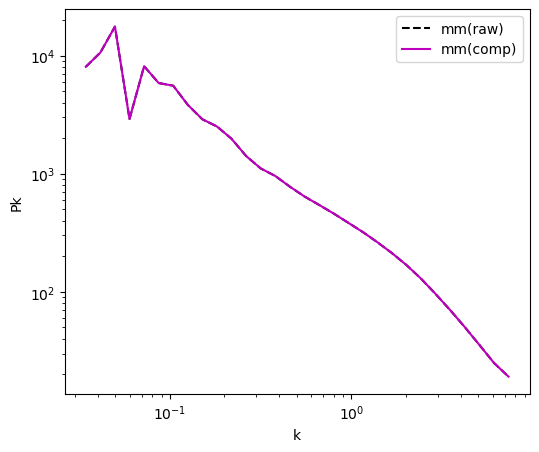

In [15]:
nrow=1;ncol=1
fig,axarr=pl.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(6*ncol,nrow*5))
#axarr=axarr.reshape(axarr.size)
axarr=[axarr]

tcol=['m','c']
for pp,ptype in enumerate(['mm']):
    pl.sca(axarr[pp])
    #pl.plot(ps.ktab,pk_dic['fits'][ptype],color=tcol[pp],ls='-',lw=2,label=ptype+ '(fits)')
    pl.plot(ps.ktab,pk_dic['raw'][ptype],color='k',ls='--',label=ptype+ '(raw)')
    pl.plot(ps.ktab,pk_dic['comp'][ptype],color='m',ls='-',label=ptype+ '(comp)')
    
    #ALso plot the matter
    #pl.plot(ps.ktab,pk_dic['fits']['mm'],color='r',ls='--',lw=2,label='mm')
    
    pl.legend()
    
pl.xscale('log')
pl.yscale('log')

pl.xlabel('k')
pl.ylabel('Pk')